# Reto Mercado Libre

**Objetivo:**
El equipo comercial quiere realizar estrategias focalizadas para los sellers, pero en este momento no existe una clasificación que permita identificar a aquellos que tienen
un buen perfil y son relevantes para el negocio. ¿Cómo podrías ayudar al equipo comercial a identificar estos sellers?

**Solución propuesta**: Modelo de Scoring de Sellers de MELI

## 1.0 Set up



In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [2]:
sns.set_style('darkgrid')
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('legend', fontsize=9)
plt.rc('font', size=13)   

In [3]:
pd.set_option('display.max_rows', 500)

## 2.0 Importar datos de la API de Ítems

Se importan los primeros 1000 artículos disponibles de la categoría de tecnología(MCO1000) en la API, haciendo un request a la URL correspondiente.

In [4]:
cat_id = 'MCO1000'
url = f'https://api.mercadolibre.com/sites/MCO/search?category={cat_id}&offset={0}'
request = requests.get(url)
items = request.json()
df_prods = pd.DataFrame.from_dict(items['results'])
offset = list(range(50,1000, 50))

for i in offset:
  url = f'https://api.mercadolibre.com/sites/MCO/search?category={cat_id}&offset={i}'
  request = requests.get(url)
  items = request.json()
  df = pd.DataFrame.from_dict(items['results'])
  df_prods = pd.concat([df_prods, df], join='outer')
df_prods.reset_index(inplace=True)

In [5]:
# Un ejemplo de un articulo extraído con la API

df_prods.sample(1).T

,699
index,49
id,MCO466715190
title,Antena Tdt De 6 Decibeles De Potencia Par Tele...
condition,new
thumbnail_id,773509-MCO43994305711_112020
catalog_product_id,None
listing_type_id,gold_pro
permalink,https://articulo.mercadolibre.com.co/MCO-46671...
buying_mode,buy_it_now
site_id,MCO


## 3.0 Selección de Características

Los datos de interés para la calificación de los sellers son: 

* seller.id
* seller.nickname
* seller.registration_date
* seller.seller_reputation
* seller.seller_reputation.level_id
* seller.seller_reputation.power_seller_status
* seller.seller_reputation.transactions
* seller.seller_reputation.ratings
* seller.seller_reputation.metrics
* installments.quantity
* installments.amount
* installments.rate

In [6]:
# Funciones de preparación de características de score de sellers

def dic_2_cols(df, col_name):
  df_temp = df[col_name].apply(pd.Series)
  df = pd.concat([df,df_temp], axis=1)
  return df

def metrics_prep(df, var):
  name = 'metrics_'+var
  df_temp = df['metrics'].apply(pd.Series)[var].apply(pd.Series)['rate']
  df_temp.rename(name, inplace=True)
  df = pd.concat([df, df_temp], axis=1)
  return df

def dummies_add(df, var):
  df_temp = pd.get_dummies(df[var])
  df = pd.concat([df, df_temp], axis=1)
  return df

In [7]:
# Pipelines de preparación de los datos
df_prods = df_prods.pipe(dic_2_cols, 'installments')\
            .pipe(dic_2_cols, 'seller')\
            .pipe(dic_2_cols, 'seller_reputation')\
            .pipe(dic_2_cols, 'transactions')\
            .pipe(dic_2_cols, 'ratings')

df_prods = df_prods.pipe(metrics_prep, 'claims')\
            .pipe(metrics_prep, 'delayed_handling_time')\
            .pipe(metrics_prep, 'cancellations')

In [8]:
[(n,i) for n,i in enumerate(df_prods.columns)]

[(0, 'index'),
 (1, 'id'),
 (2, 'title'),
 (3, 'condition'),
 (4, 'thumbnail_id'),
 (5, 'catalog_product_id'),
 (6, 'listing_type_id'),
 (7, 'permalink'),
 (8, 'buying_mode'),
 (9, 'site_id'),
 (10, 'category_id'),
 (11, 'domain_id'),
 (12, 'thumbnail'),
 (13, 'currency_id'),
 (14, 'order_backend'),
 (15, 'price'),
 (16, 'original_price'),
 (17, 'sale_price'),
 (18, 'sold_quantity'),
 (19, 'available_quantity'),
 (20, 'official_store_id'),
 (21, 'use_thumbnail_id'),
 (22, 'accepts_mercadopago'),
 (23, 'tags'),
 (24, 'shipping'),
 (25, 'stop_time'),
 (26, 'seller'),
 (27, 'seller_address'),
 (28, 'address'),
 (29, 'attributes'),
 (30, 'installments'),
 (31, 'winner_item_id'),
 (32, 'catalog_listing'),
 (33, 'discounts'),
 (34, 'promotions'),
 (35, 'inventory_id'),
 (36, 'official_store_name'),
 (37, 'differential_pricing'),
 (38, 'variation_filters'),
 (39, 'variations_data'),
 (40, 'quantity'),
 (41, 'amount'),
 (42, 'rate'),
 (43, 'currency_id'),
 (44, 'id'),
 (45, 'nickname'),
 (46, 

In [108]:
df_prods['quantity'].value_counts()

36    765
12    235
Name: quantity, dtype: int64

<Axes: >

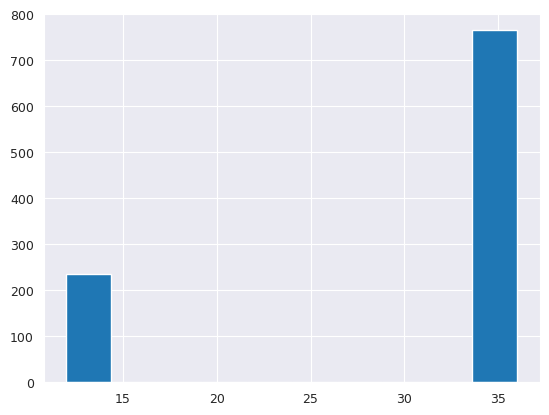

In [109]:
df_prods['quantity'].hist()

In [9]:
# Covertir JSON en columnas

df_temp = df_prods['metrics'].apply(pd.Series)['sales'].apply(pd.Series)
df_temp.rename({'period':'period_sales','completed':'completed_sales'}, inplace=True, axis=1)
df_prods = pd.concat([df_prods, df_temp], axis=1)

In [10]:
# Fecha de registro a días registrado

df_prods['registration_date'] = df_prods.apply(lambda x: x['registration_date'].split('T')[0], axis=1)
df_prods['registration_date'] = pd.to_datetime(df_prods['registration_date'])
df_prods['history'] = datetime(2023, 5, 1) - df_prods['registration_date']
df_prods['history'] = df_prods['history']/ np.timedelta64(1, 'D')
df_prods['history'] = df_prods['history'].astype(int)

In [116]:
df_prods['history'].describe()

count    1000.000000
mean     2636.149000
std      1861.607654
min        10.000000
25%      1090.000000
50%      2251.000000
75%      3714.000000
max      7889.000000
Name: history, dtype: float64

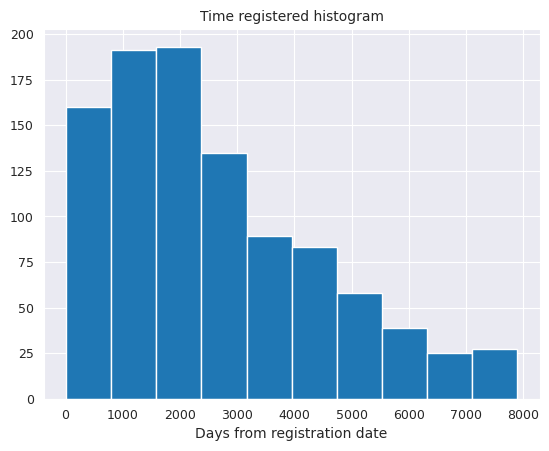

In [11]:
df_prods['history'].hist()
plt.title('Time registered histogram')
plt.xlabel('Days from registration date')
plt.show()

## 4.0 Ingeniería de características

In [12]:
# Construcción de la muestra

vars = ['id','nickname','registration_date','canceled', 'completed','period', 'negative','positive','neutral','total',
        'power_seller_status','metrics_claims','metrics_delayed_handling_time', 'metrics_cancellations','period_sales',
        'completed_sales','amount','rate','currency_id','level_id','power_seller_status', 'history']

X = df_prods.loc[:,vars]

In [13]:
X.iloc[0,:]

id                                     MCO1341701368
id                                         139705540
nickname                                MUNDONET2513
registration_date                2013-06-04 00:00:00
canceled                                         791
completed                                      23802
period                                      historic
negative                                        0.01
positive                                        0.98
neutral                                         0.01
total                                          24593
power_seller_status                         platinum
metrics_claims                                 0.003
metrics_delayed_handling_time                  0.002
metrics_cancellations                         0.0002
period_sales                                 60 days
completed_sales                                 3820
amount                                       3031.81
rate                                          

In [14]:
# Cambiar nombres de columnas duplicadas, y eliminar columnas duplicadas

names = X.columns.to_list()
names[1] = 'id_seller'
X.set_axis(names, axis=1, inplace= True)
X = X.loc[:,~X.columns.duplicated()]

X.columns, X.columns.duplicated()

<ipython-input-14-2092eed63d5d>:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  X.set_axis(names, axis=1, inplace= True)


(Index(['id', 'id_seller', 'nickname', 'registration_date', 'canceled',
        'completed', 'period', 'negative', 'positive', 'neutral', 'total',
        'power_seller_status', 'metrics_claims',
        'metrics_delayed_handling_time', 'metrics_cancellations',
        'period_sales', 'completed_sales', 'amount', 'rate', 'currency_id',
        'level_id', 'history'],
       dtype='object'),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False]))

In [15]:
X['id_seller']

0       139705540
1       244782814
2      1051017434
3       363713608
4         8019088
          ...    
995     611113384
996     102708717
997      86356308
998     110187976
999     238038329
Name: id_seller, Length: 1000, dtype: int64

In [16]:
# Verificación de días registrados

# temp = X.groupby(['id_seller'])['history'].first()
# temp = temp.reset_index()
# def verify(x):
#   return temp[temp['id_seller']==x['id_seller']]['history']==x['history']

# X['verify'] = X.apply(lambda x: verify(x), axis=1)
# X['verify'].value_counts()

In [17]:
# X = X.pipe(dummies_add, 'period_sales')
# X = X.pipe(dummies_add, 'power_seller_status')
X = X.pipe(dummies_add, 'power_seller_status').pipe(dummies_add,'period_sales').pipe(dummies_add, 'level_id')

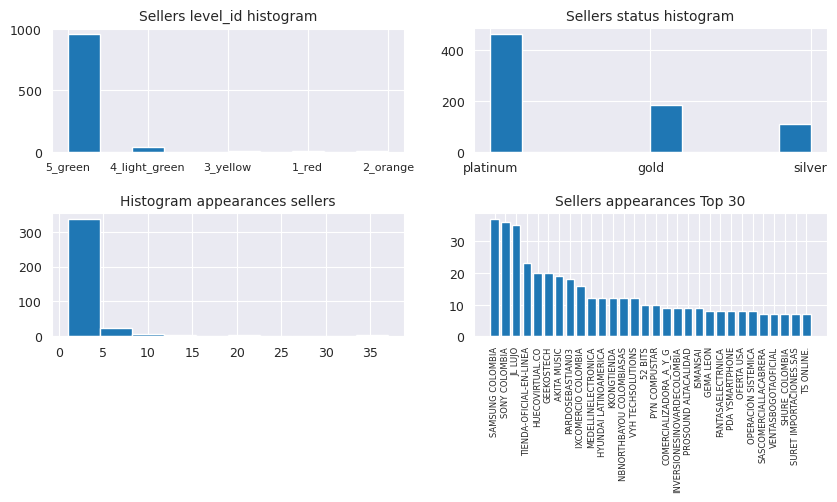

In [18]:
fig, ax = plt.subplots(nrows =2, ncols=2, figsize=(10,4))
fig.subplots_adjust(hspace=.5)

temp = X.groupby('nickname').count()['id']
temp = temp.copy()
temp.sort_values(ascending=False, inplace=True)

temp.hist(ax=ax[1,0])
ax[1,0].set_title('Histogram appearances sellers')

ax[1,1].bar(temp.index[:30], temp.values[:30])
ax[1,1].tick_params(axis='x', rotation=90, labelsize=6)
ax[1,1].set_title('Sellers appearances Top 30')

X['power_seller_status'].hist(ax=ax[0,1])
ax[0,1].set_title('Sellers status histogram')

X['level_id'].hist(ax=ax[0,0])
ax[0,0].set_title('Sellers level_id histogram')
ax[0,0].tick_params(axis='x', labelsize=8)

plt.show()

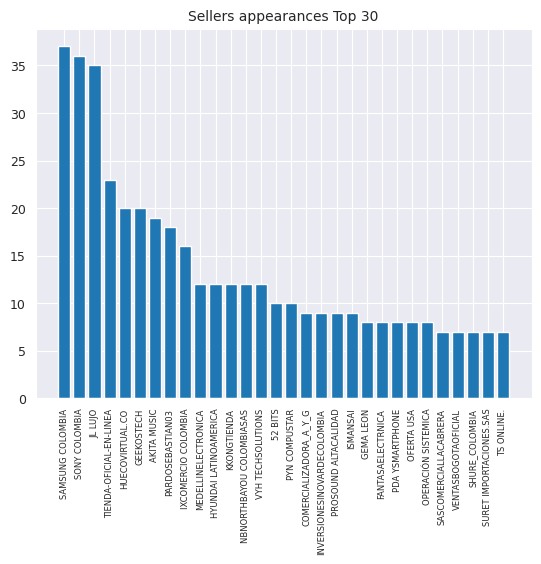

In [115]:
plt.bar(temp.index[:30], temp.values[:30])
plt.tick_params(axis='x', rotation=90, labelsize=6)
plt.title('Sellers appearances Top 30')
plt.show()

In [19]:
X.level_id.value_counts()

5_green          954
4_light_green     35
3_yellow           8
1_red              2
2_orange           1
Name: level_id, dtype: int64

In [20]:
X.isna().sum()

id                                 0
id_seller                          0
nickname                           0
registration_date                  0
canceled                           0
completed                          0
period                             0
negative                           0
positive                           0
neutral                            0
total                              0
power_seller_status              246
metrics_claims                     0
metrics_delayed_handling_time      0
metrics_cancellations              0
period_sales                       0
completed_sales                    0
amount                             0
rate                               0
currency_id                        0
level_id                           0
history                            0
gold                               0
platinum                           0
silver                             0
365 days                           0
60 days                            0
1

In [21]:
X['power_seller_status'].value_counts(dropna=False)

platinum    463
None        246
gold        183
silver      108
Name: power_seller_status, dtype: int64

In [22]:
X['power_seller_status'].fillna('Other', inplace=True)

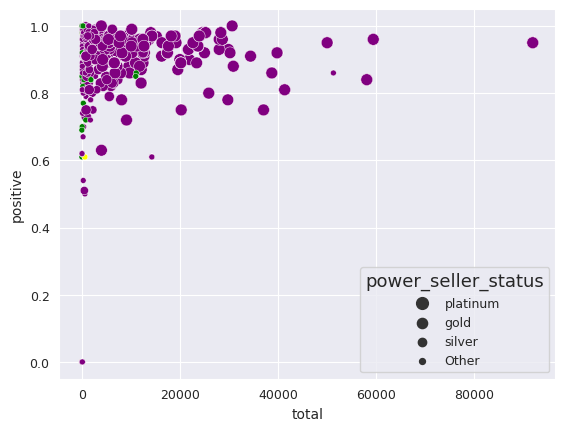

In [23]:
dic = {'1_red':'red',
       '2_orange':'orange',
       '3_yellow':'yellow',
       '4_light_green':'green',
       '5_green':'purple'}

colors = X['level_id'].apply(lambda x: dic[x])
sns.scatterplot(data=X, x="total", y="positive", size="power_seller_status", c=colors, legend=True)

plt.show()

In [24]:
# Verificación de valores válidos de variables
# Las variables tienen valores únicos entonces se descartan estas características

X['period'].value_counts(), X['rate'].value_counts(), X['currency_id'].value_counts() 

(historic    1000
 Name: period, dtype: int64,
 0    1000
 Name: rate, dtype: int64,
 COP    1000
 Name: currency_id, dtype: int64)

In [30]:
X['power_seller_status']

0      platinum
1      platinum
2          gold
3          gold
4          gold
         ...   
995      silver
996    platinum
997      silver
998    platinum
999    platinum
Name: power_seller_status, Length: 1000, dtype: object

In [ ]:
# Descarte de columnas no interesantes 

X.drop(['level_id', 'id', 'registration_date', \
        'nickname', 'rate', 'currency_id','period','power_seller_status','period_sales'], axis=1, inplace=True)
X.head(10)

## 5.0 Modelado

**[Inertia](https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet)** measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import itertools, random

In [27]:
X.columns

Index(['id_seller', 'canceled', 'completed', 'negative', 'positive', 'neutral',
       'total', 'power_seller_status', 'metrics_claims',
       'metrics_delayed_handling_time', 'metrics_cancellations',
       'period_sales', 'completed_sales', 'amount', 'history', 'gold',
       'platinum', 'silver', '365 days', '60 days', '1_red', '2_orange',
       '3_yellow', '4_light_green', '5_green'],
      dtype='object')

### 5.1 Exp 1

In [43]:
# Optimizamos la distancia entre los items de los clusters. La homogeneidad entre clusters (intracluster)
# Maximizar la distancia intercluster

X_km = X.drop('id_seller', axis=1)
Sum_of_squared_distances = []

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, n_init=10, max_iter=50)
    km = km.fit(X_km.values)
    Sum_of_squared_distances.append(km.inertia_)

In [44]:
kmeans = KMeans(n_clusters= 3, random_state = 123)
kmeans.fit(X_km.values)

X_km['pred'] = kmeans.predict(X_km)
X_km['pred'] = X_km['pred'].astype(object)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


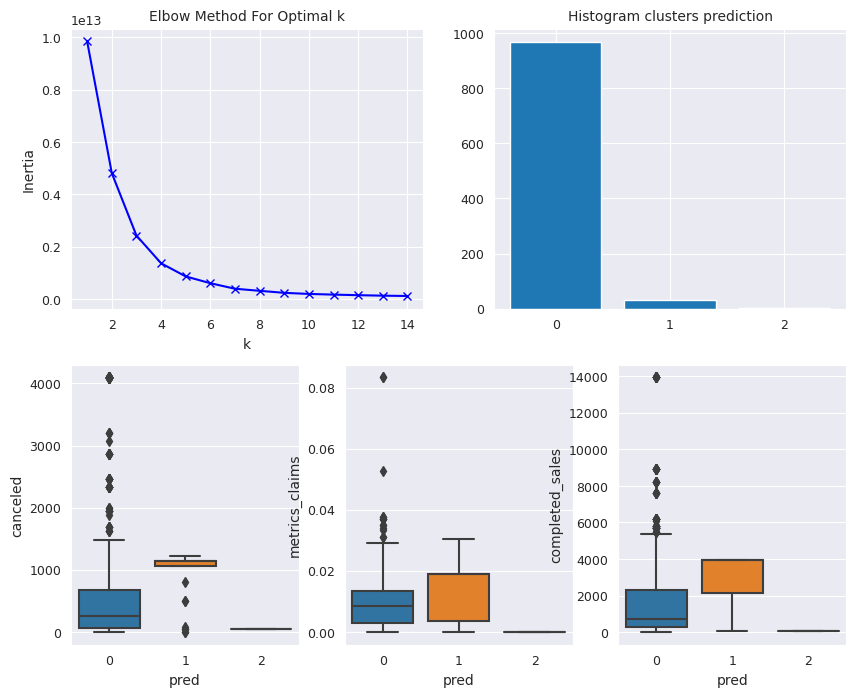

In [45]:
fig= plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(K, Sum_of_squared_distances, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method For Optimal k')

ax2 = fig.add_subplot(2,2,2)
ax2.bar(X_km['pred'].value_counts().index, X_km['pred'].value_counts().values)
ax2.set_title('Histogram clusters prediction')
ax2.set_xticks([0,1,2])

ax3 = fig.add_subplot(2, 3, 4)
sns.boxplot(data=X_km, x='pred', y='canceled', ax=ax3)

ax4 = fig.add_subplot(2, 3, 5)
sns.boxplot(data=X_km, x='pred', y='metrics_claims', ax=ax4)

ax5 = fig.add_subplot(2, 3, 6)
sns.boxplot(data=X_km, x='pred', y='completed_sales', ax=ax5)

plt.show()


### 5.2 Exp 2

In [ ]:
X.columns

In [ ]:
# Optimizamos la distancia entre los items de los clusters. La homogeneidad entre clusters (intracluster)
# Maximizar la distancia intercluster

X_km = X.drop(['id_seller', 'history', 'gold',
       'platinum', 'silver', '365 days', '60 days', '1_red', '2_orange',
       '3_yellow', '4_light_green', '5_green','total','canceled_std',
       'completed_std', 'total_std', 'completed_sales_std'], axis=1)
Sum_of_squared_distances = []


K = range(1,15)
seeds = list(range(5))
for k,s in zip(K, seeds):
    km = KMeans(n_clusters=k, n_init='auto', init='random', max_iter=500, random_state=s)
    km = km.fit(X_km.values)
    Sum_of_squared_distances.append(km.inertia_)

In [ ]:
kmeans = KMeans(n_clusters= 3, random_state = 123)
kmeans.fit(X_km.values)

X_km['pred'] = kmeans.predict(X_km.values)
X_km['pred'] = X_km['pred'].astype(object)

In [ ]:
X_km

In [ ]:
from sklearn.cluster import KMeans

for seed, true_k in zip(range(5),K):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=800,
        n_init=50,
        random_state=seed,
    ).fit(X_km)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements asigned to each cluster: {cluster_sizes}")
print()
# print(
#     "True number of documents in each category according to the class labels: "
#     f"{category_sizes}"
# )

In [ ]:
fig= plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(2,2,1)
# ax1.plot(K, Sum_of_squared_distances, 'bx-')
# ax1.set_xlabel('k')
# ax1.set_ylabel('Inertia')
# ax1.set_title('Elbow Method For Optimal k')

ax2 = fig.add_subplot(2,2,2)
ax2.bar(X_km['pred'].value_counts().index, X_km['pred'].value_counts().values)
ax2.set_title('Histogram clusters prediction')
ax2.set_xticks([0,1,2])

ax3 = fig.add_subplot(2, 3, 4)
sns.boxplot(data=X_km, x='pred', y='canceled', ax=ax3)

ax4 = fig.add_subplot(2, 3, 5)
sns.boxplot(data=X_km, x='pred', y='metrics_claims', ax=ax4)

ax5 = fig.add_subplot(2, 3, 6)
sns.boxplot(data=X_km, x='pred', y='completed_sales', ax=ax5)

plt.show()

### 5.3 Exp 3

In [46]:
X_km3 = X.loc[:, ['canceled', 'completed','metrics_claims','metrics_delayed_handling_time', 'metrics_cancellations', 'completed_sales']]
Sum_of_squared_distances = []


K = range(1,15)
seeds = list(range(5))
for k,s in zip(K, seeds):
    km = KMeans(n_clusters=k, n_init='auto', init='random', max_iter=500, random_state=s)
    km = km.fit(X_km3.values)
    Sum_of_squared_distances.append(km.inertia_)

In [47]:
X_km3.head()

,canceled,completed,metrics_claims,metrics_delayed_handling_time,metrics_cancellations,completed_sales
0,791,23802,0.0030,0.0020,0.0002,3820
1,385,5349,0.0101,0.0579,0.0000,657
2,154,1343,0.0124,0.0025,0.0000,720
3,26,842,0.0028,0.0000,0.0000,336
4,213,2523,0.0105,0.0176,0.0000,446


In [48]:
kmeans = KMeans(n_clusters= 3, random_state = 123)
kmeans.fit(X_km3.values)

X_km3['pred'] = kmeans.predict(X_km3.values)
X_km3['pred'] = X_km3['pred'].astype(object)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


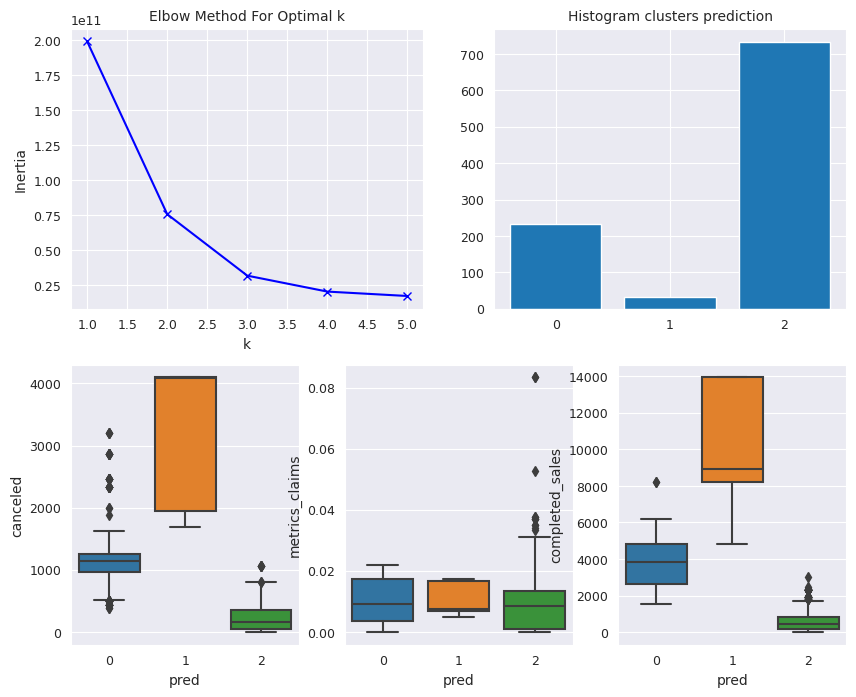

In [49]:
fig= plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(list(K)[:5], Sum_of_squared_distances, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method For Optimal k')

ax2 = fig.add_subplot(2,2,2)
ax2.bar(X_km3['pred'].value_counts().index, X_km3['pred'].value_counts().values)
ax2.set_title('Histogram clusters prediction')
ax2.set_xticks([0,1,2])

ax3 = fig.add_subplot(2, 3, 4)
sns.boxplot(data=X_km3, x='pred', y='canceled', ax=ax3)

ax4 = fig.add_subplot(2, 3, 5)
sns.boxplot(data=X_km3, x='pred', y='metrics_claims', ax=ax4)

ax5 = fig.add_subplot(2, 3, 6)
sns.boxplot(data=X_km3, x='pred', y='completed_sales', ax=ax5)

plt.show()

## 6.0 Ingeniería de Características

In [50]:
# Estandarización de variables

cols_norm = ['canceled', 'completed','total','completed_sales']
cols_norm_nn = [i+'_std' for i in cols_norm]

def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

X_6 = X.copy()
X_6[cols_norm_nn] = mean_norm(X[cols_norm])

In [51]:
X_6.iloc[110,:]

id_seller                        9.189693e+07
canceled                         2.454000e+03
completed                        3.629100e+04
negative                         1.100000e-01
positive                         8.600000e-01
neutral                          3.000000e-02
total                            3.874500e+04
metrics_claims                   1.150000e-02
metrics_delayed_handling_time    1.970000e-02
metrics_cancellations            1.180000e-02
completed_sales                  5.681000e+03
amount                           1.295690e+03
history                          6.276000e+03
gold                             0.000000e+00
platinum                         1.000000e+00
silver                           0.000000e+00
365 days                         0.000000e+00
60 days                          1.000000e+00
1_red                            0.000000e+00
2_orange                         0.000000e+00
3_yellow                         0.000000e+00
4_light_green                    0

In [ ]:
X_6

### 6.1 Exp 4

In [55]:
# Optimizamos la distancia entre los items de los clusters. La homogeneidad entre clusters (intracluster)
# Maximizar la distancia intercluster

X_6.drop(cols_norm, axis=1, inplace=True)
X_6.drop(['id_seller','gold','platinum', 'silver','1_red', '2_orange',\
               '3_yellow', '4_light_green', '5_green'], axis=1, inplace=True)
Sum_of_squared_distances = []


K = range(1,10)

for k in K:
    km = KMeans(n_clusters=k, n_init='auto', init='random', max_iter=500, random_state=random.randint(0,1000))
    km = km.fit(X_6.values)
    Sum_of_squared_distances.append(km.inertia_)

In [56]:
# kmeans = KMeans(n_clusters= 3)
km.fit(X_6.values)

X_6['pred'] = km.labels_
X_6['pred'] = X_6['pred'].astype(object)

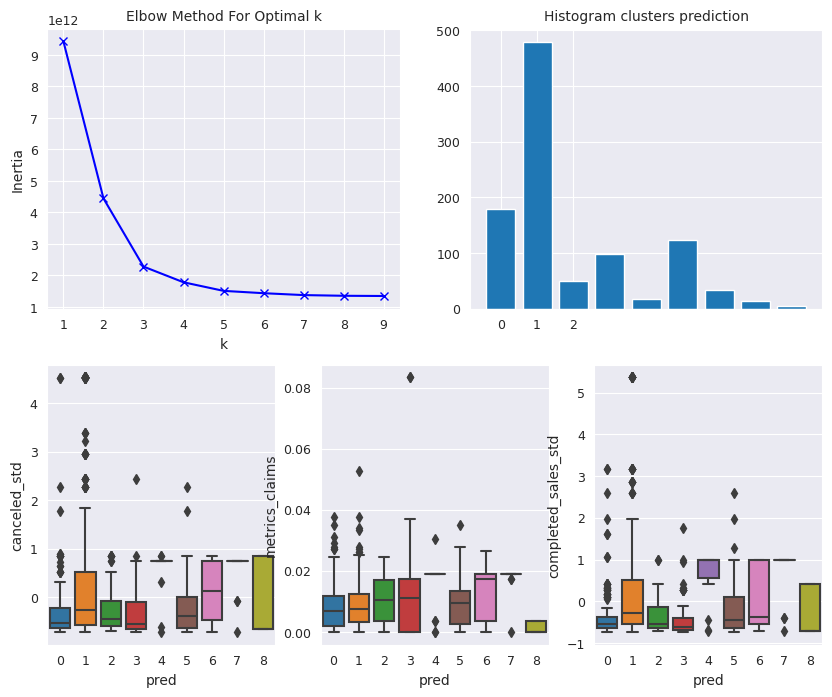

In [57]:
fig= plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(K, Sum_of_squared_distances, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method For Optimal k')

ax2 = fig.add_subplot(2,2,2)
ax2.bar(X_6['pred'].value_counts().index, X_6['pred'].value_counts().values)
ax2.set_title('Histogram clusters prediction')
ax2.set_xticks([0,1,2])

ax3 = fig.add_subplot(2, 3, 4)
sns.boxplot(data=X_6, x='pred', y='canceled_std', ax=ax3)

ax4 = fig.add_subplot(2, 3, 5)
sns.boxplot(data=X_6, x='pred', y='metrics_claims', ax=ax4)

ax5 = fig.add_subplot(2, 3, 6)
sns.boxplot(data=X_6, x='pred', y='completed_sales_std', ax=ax5)

plt.show()


## 7.0 Clasificación de categoría

El modelo 3 fue el mejor en cuanto a la diferenciación de las variables más interesantes: *completed_sales* y *canceled*. Esto puede variar dependiendo de la necesidad de negocio. A pesar de que el experimento 4 consiguió la menor inercia la selección del modelo puede constar de otros factores.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from numpy.random import random
from mpl_toolkits.mplot3d import Axes3D

In [59]:
# Preparación de la muestra
Xy = pd.concat([X['id_seller'],X_km3], axis=1)

In [60]:
# Datos y etiquetas
X = Xy.drop(['id_seller','pred'], axis=1)
y = Xy['pred']

In [61]:
# Muestra de entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

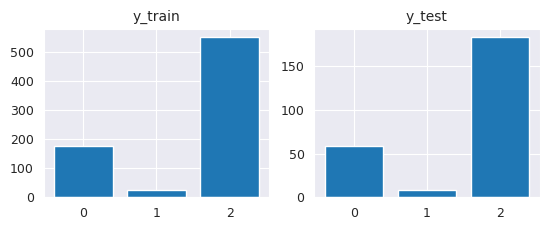

In [62]:
fig = plt.figure()

ax = fig.add_subplot(2,2,1)
ax.bar(y_train.value_counts().index,y_train.value_counts().values)
ax.set_title('y_train')

ax1 = fig.add_subplot(2,2,2)
ax1.bar(y_test.value_counts().index,y_test.value_counts().values)
ax1.set_title('y_test')

plt.show()

In [63]:
X_train

,canceled,completed,metrics_claims,metrics_delayed_handling_time,metrics_cancellations,completed_sales
613,201,3984,0.0180,0.0767,0.0115,733
490,35,539,0.0000,0.0103,0.0000,93
797,1939,57497,0.0070,0.0031,0.0016,7587
231,280,3492,0.0000,0.0000,0.0000,724
163,139,1951,0.0157,0.1333,0.0078,241
...,...,...,...,...,...,...
85,107,524,0.0376,0.0769,0.0171,235
756,384,4777,0.0241,0.0547,0.0080,589
845,9,90,0.0000,0.0853,0.0101,90
166,35,964,0.0000,0.0239,0.0030,964


In [64]:
Xy.isna().sum()

id_seller                        0
canceled                         0
completed                        0
metrics_claims                   0
metrics_delayed_handling_time    0
metrics_cancellations            0
completed_sales                  0
pred                             0
dtype: int64

In [65]:
# Clasificación con regresión logística multinomial
lr = LogisticRegression(multi_class='multinomial')
lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [66]:
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

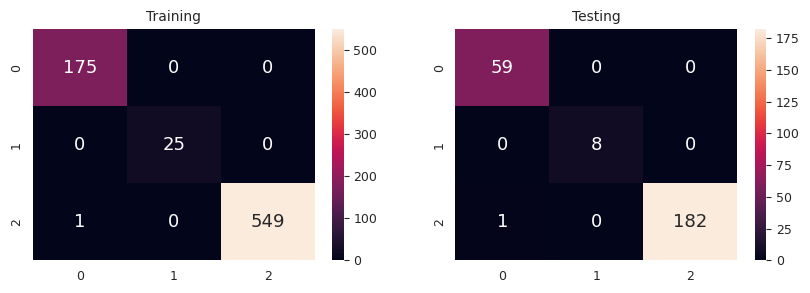

In [67]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

training = confusion_matrix(y_train, y_pred_train)
sns.heatmap(training, annot=True, cmap='rocket', ax=ax[0], fmt='g')
ax[0].set_title('Training')

testing = confusion_matrix(y_test, y_pred)
sns.heatmap(testing, annot=True, cmap='rocket', ax=ax[1], fmt='g')
ax[1].set_title('Testing')
 
plt.show()

In [87]:
print('Precisión de la predicción en entrenamiento: {0:.2f}%'.format((testing.diagonal()/testing.sum(axis=1))[2]*100))
print('Precisión de la predicción en evaluación: {0:.2f}%'.format((training.diagonal()/training.sum(axis=1))[2]*100))


Precisión de la predicción en entrenamiento: 99.45%
Precisión de la predicción en evaluación: 99.82%


## 8.0 Resultados

In [90]:
X_km3

,canceled,completed,metrics_claims,metrics_delayed_handling_time,metrics_cancellations,completed_sales,pred
0,791,23802,0.0030,0.0020,0.0002,3820,0
1,385,5349,0.0101,0.0579,0.0000,657,2
2,154,1343,0.0124,0.0025,0.0000,720,2
3,26,842,0.0028,0.0000,0.0000,336,2
4,213,2523,0.0105,0.0176,0.0000,446,2
...,...,...,...,...,...,...,...
995,78,1696,0.0000,0.0172,0.0000,228,2
996,279,7614,0.0018,0.0019,0.0000,1537,2
997,50,1184,0.0000,0.0061,0.0000,161,2
998,890,23066,0.0062,0.0022,0.0008,3556,0


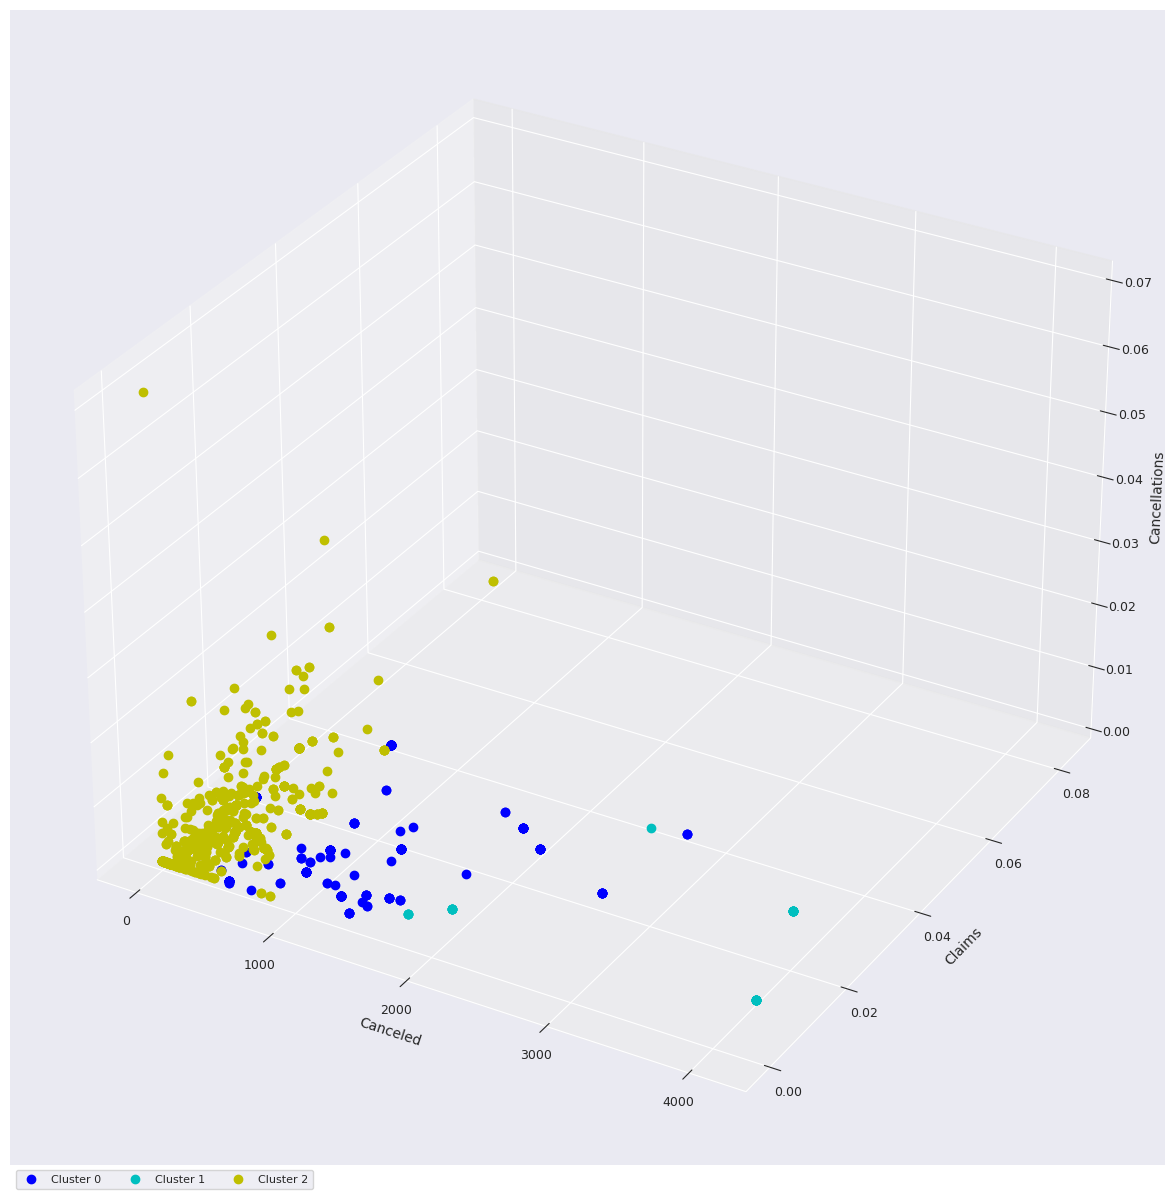

In [91]:
colors=['b', 'c', 'y', 'm', 'r']

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

X_0 = X_km3.query('pred == 0')
X_1 = X_km3.query('pred == 1')
X_2 = X_km3.query('pred == 2')

ax.plot(X_0['canceled'],X_0['metrics_claims'], X_0['metrics_cancellations'], 'o', color=colors[0], label='Cluster 0')
ax.plot(X_1['canceled'],X_1['metrics_claims'], X_1['metrics_cancellations'], 'o', color=colors[1], label='Cluster 1')
ax.plot(X_2['canceled'],X_2['metrics_claims'], X_2['metrics_cancellations'], 'o', color=colors[2], label='Cluster 2')

ax.set_xlabel('Canceled')
ax.set_ylabel('Claims')
ax.set_zlabel('Cancellations')

plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))

plt.show()

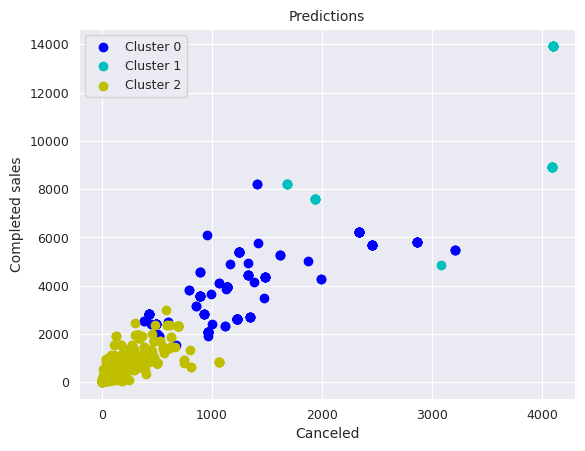

In [119]:
colors=['b', 'c', 'y', 'm', 'r']
X_0 = X_km3.query('pred == 0')
X_1 = X_km3.query('pred == 1')
X_2 = X_km3.query('pred == 2')

plt.scatter(X_0['canceled'],X_0['completed_sales'], c = colors[0], label='Cluster 0')
plt.scatter(X_1['canceled'],X_1['completed_sales'], c = colors[1], label='Cluster 1')
plt.scatter(X_2['canceled'],X_2['completed_sales'], c = colors[2], label='Cluster 2')

plt.legend(loc='upper left')
plt.xlabel('Canceled')
plt.ylabel('Completed sales')
plt.title('Predictions')

plt.show()

In [94]:
X_km3.query('pred == 0').describe()

,canceled,completed,metrics_claims,metrics_delayed_handling_time,metrics_cancellations,completed_sales
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,1245.333333,21385.329060,0.009949,0.015011,0.005118,3771.162393
std,596.740129,7351.105535,0.006373,0.021605,0.005931,1347.116679
min,382.000000,13143.000000,0.000000,0.000000,0.000000,1559.000000
25%,957.250000,16505.000000,0.003600,0.000800,0.000400,2622.000000
50%,1139.000000,19273.000000,0.009100,0.004600,0.002100,3820.000000
75%,1249.000000,23066.000000,0.017400,0.019700,0.011450,4804.500000
max,3208.000000,38503.000000,0.021800,0.077200,0.015200,8201.000000


In [95]:
X_km3.query('pred == 1').describe()

,canceled,completed,metrics_claims,metrics_delayed_handling_time,metrics_cancellations,completed_sales
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,3379.575758,66092.545455,0.010194,0.009264,0.004776,10290.363636
std,1050.309122,16922.951641,0.004842,0.010614,0.004538,2896.796968
min,1683.000000,48228.000000,0.004800,0.002000,0.000400,4848.000000
25%,1939.000000,54016.000000,0.007000,0.002000,0.001600,8225.000000
50%,4094.000000,57497.000000,0.007500,0.003100,0.002200,8914.000000
75%,4095.000000,87857.000000,0.016800,0.013900,0.010400,13931.000000
max,4095.000000,87857.000000,0.017200,0.057300,0.016000,13931.000000


In [96]:
X_km3.query('pred == 2').describe()

,canceled,completed,metrics_claims,metrics_delayed_handling_time,metrics_cancellations,completed_sales
count,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000
mean,217.264666,3763.010914,0.009144,0.018016,0.002675,637.064120
std,207.026999,3485.070396,0.008984,0.025212,0.004982,577.864341
min,0.000000,12.000000,0.000000,0.000000,0.000000,12.000000
25%,50.000000,842.000000,0.001100,0.000000,0.000000,196.000000
50%,154.000000,2523.000000,0.008400,0.010800,0.000000,450.000000
75%,350.000000,5854.000000,0.013500,0.024600,0.003400,827.000000
max,1061.000000,12494.000000,0.083300,0.250000,0.071400,2997.000000


**Fuentes:**

1. [Clustering: K-Means](https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet). Code Academy. 
2. [Precision multiclass](https://wbarriosb.medium.com/calculando-la-precisi%C3%B3n-en-un-modelo-de-clasificaci%C3%B3n-multiclase-224d96f52043). Medium